# NLP Project: Misinformation detection (test with BERT feature extractor)

<div style="text-align: center;">
    <img src="image/fake_news.jpeg" alt="Exemple d'image" style="width: 30%;"/>
</div>

---



In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import pickle

# Présenation : 

<div style="text-align: center;">
    <img src="image/illustration2.png" alt="Exemple d'image" style="width: 50%;"/>
</div>


**Objectif** : Transformer les textes en une représentation numérique : 

    - Sentence embeddings (BERT, RoBERTa)

## Étape 1 : Analyse exploratoire des données (EDA)

Fake news dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   label    23481 non-null  object
dtypes: object(5)
memory usage: 917.4+ KB
None

True news dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   label    21417 non-null  object
dtypes: object(5)
memory usage: 836.7+ KB
None

Combined dataset:
label
fake    23481
true    21417
Name: count, dtype: int64


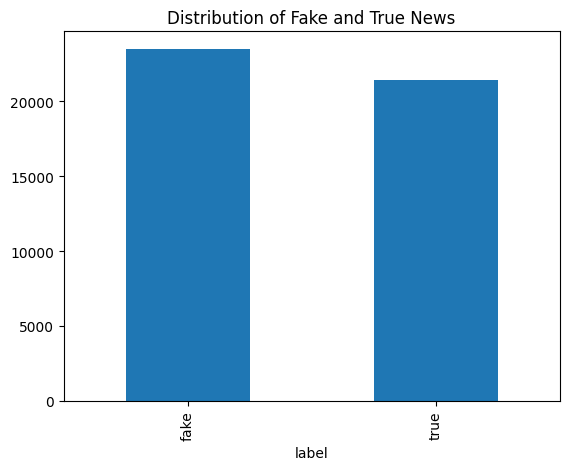

In [2]:
from src.eda import load_and_explore_data

data = load_and_explore_data('data/Fake.csv', 'data/True.csv')

### Statistiques descriptives sur les longueurs

## Étape 2 : Prétraitement des données

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Télécharger les ressources nécessaires de NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialiser les stopwords et le lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convertir en minuscules
    text = text.lower()
    # Supprimer les caractères spéciaux et les chiffres
    text = re.sub(r'[^a-z\s]', '', text)
    # Supprimer les stopwords et appliquer la lemmatisation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Appliquer le prétraitement sur les colonnes 'title' et 'text'
data['cleaned_title'] = data['title'].apply(preprocess_text)
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Afficher un exemple avant et après le nettoyage
print("Exemple avant nettoyage :")
print(data['text'].iloc[0])
print("\nExemple après nettoyage :")
print(data['cleaned_text'].iloc[0])

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-a/2024/amine.razig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /users/eleves-a/2024/amine.razig/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /users/eleves-a/2024/amine.razig/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Exemple avant nettoyage :
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His

## Étape 3 : Représentation des textes **BERT**
#### L'objectif est de transformer les textes en une représentation numérique. On test diffrentes approches : 

In [9]:
# Charger le tokenizer et le modèle DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = bert_model.to(device)

# Fonction pour obtenir les embeddings BERT par lots
def get_bert_embeddings_batch(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        tokens = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = bert_model(**tokens)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())  # CLS token
    return np.vstack(embeddings)

# Générer ou charger les embeddings
embeddings_file = 'bert_embeddings.pkl'
try:
    with open(embeddings_file, 'rb') as f:
        X = pickle.load(f)
    print("Embeddings chargés depuis le fichier.")
except FileNotFoundError:
    print("Génération des embeddings...")
    X = get_bert_embeddings_batch(data['cleaned_text'].tolist(), batch_size=16)
    with open(embeddings_file, 'wb') as f:
        pickle.dump(X, f)
    print("Embeddings sauvegardés.")

Génération des embeddings...
Embeddings sauvegardés.


In [10]:
from sklearn.preprocessing import LabelEncoder

# Encodage des étiquettes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'])

print("Shape of X:", X.shape)
print("Length of y:", len(y))

Shape of X: (44898, 768)
Length of y: 44898


## Étape 4 : Modélisation classique
Objectif : Utiliser des modèles de machine learning classiques pour classifier les textes.

In [11]:
from sklearn.model_selection import train_test_split

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Régression logistique
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

# Évaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.988641425389755

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Régression logistique
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logistic))

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

# Linear SVC
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Logistic Regression Accuracy: 0.988641425389755

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Naive Bayes Accuracy: 0.8994432071269488

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      4733
           1       0.92      0.87      0.89      4247

    accuracy                           0.90      8980
   macro avg       0.90      0.90      0.90      8980
weighted avg       0.90      0.90      0.90      8980

SVM Accuracy: 0.993652561247216

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.99      0.99      0.

# Generalisation sur les nouvelles données

In [15]:

new_data = pd.read_csv('data/corpus_combined_dataset.csv')

# Prétraiter les textes
new_data['cleaned_statement'] = new_data['Statement'].apply(preprocess_text)

# Générer les embeddings BERT pour les nouvelles données
new_embeddings = get_bert_embeddings_batch(new_data['cleaned_statement'].tolist(), batch_size=16)

# Prédire les labels avec les modèles déjà entraînés
y_pred_logistic_new = logistic_model.predict(new_embeddings)
y_pred_nb_new = nb_model.predict(new_embeddings)
y_pred_svm_new = svm_model.predict(new_embeddings)
y_pred_rf_new = rf_model.predict(new_embeddings)

# Calculer l'accuracy pour chaque modèle
y_true_new = np.abs(1 - new_data['label'].values)
print("Logistic Regression Accuracy:", accuracy_score(y_true_new, y_pred_logistic_new))
print("Naive Bayes Accuracy:", accuracy_score(y_true_new, y_pred_nb_new))
print("SVM Accuracy:", accuracy_score(y_true_new, y_pred_svm_new))
print("Random Forest Accuracy:", accuracy_score(y_true_new, y_pred_rf_new))

Logistic Regression Accuracy: 0.5416805048156759
Naive Bayes Accuracy: 0.6027897708402524
SVM Accuracy: 0.5433410826967785
Random Forest Accuracy: 0.5450016605778811


**Observations :**

>Comme pour les autres combinaisons de feature extractors et de modèles, nous observons que la qualité des > prédictions se détériore fortement lorsque nous appliquons les modèles à de nouvelles données différentes de celles utilisées pour l'entraînement. Cela souligne l'importance cruciale des capacités de généralisation offertes par les méthodes avancées de NLP dans le cadre de la détection de fausses informations. Ces résultats mettent en évidence la nécessité d'utiliser des approches robustes et adaptées pour traiter des données variées et imprévisibles dans des contextes réels.